In [1]:
import sys
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk"))

# ROOT!
import os, sys
os.environ["ROOTSYS"] = "/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/software/ROOT/ROOT_6.26.14/install"
sys.path.append(os.path.join(os.environ["ROOTSYS"], "lib"))

import hipy.hipy.pltext  as pltext
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import pandas            as pd

from nHits_trigger.src.read_data          import nHits, read_mpmt_offsets
from WCTE_BRB_Data_Analysis.wcte.brbtools import sort_run_files, get_part_files

from tqdm import tqdm

pltext.style()

In [2]:
datapath="/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/nicf_data/data/"
filename="run_1767_signal_N20candidates_unfiltered.csv"
data = pd.read_csv(datapath+filename)

In [3]:
data

,event_id,hit_pmt_calibrated_times,hit_pmt_charges,hit_mpmt_card_ids,hit_mpmt_slot_ids,hit_pmt_channel_ids,hit_pmt_position_ids
0,0.0,53683.787124,117.0,108.0,3.0,14.0,13.0
1,0.0,53691.537798,100.0,102.0,22.0,10.0,10.0
2,1.0,63479.663380,83.0,12.0,1.0,15.0,5.0
3,1.0,63480.392541,133.0,36.0,46.0,13.0,12.0
4,1.0,63496.106182,180.0,96.0,8.0,15.0,5.0
...,...,...,...,...,...,...,...
8705717,1018209.0,376215.421834,53.0,76.0,86.0,17.0,15.0
8705718,1018210.0,433661.640903,432.0,109.0,104.0,11.0,11.0
8705719,1018210.0,433661.712431,366.0,109.0,104.0,13.0,12.0
8705720,1018211.0,468920.948412,126.0,33.0,83.0,16.0,14.0


In [4]:
#HISTOGRAMA DE HITS POR EVENTO, prueba1

#cada fila de datos es un hit=llega un fotón
#Evento: período de tiempo fijo en el que se recogen hits

In [ ]:
#1º) Agrupo los hits en sus respectivos eventos

# Tenemos 8705722 hits en total, pero queremos agruparlos en el evento en el que llegaron: evento 0, 1,..., 1018211 (event_id)

data_by_event=data.groupby("event_id") # .groupby("event_id") toma todas las filas con el mismo event_id y las junta en grupos

print(len(data_by_event)) #para ver cuántos grupos tengo uso len(); lo imprimo para verlo
#este es el nº de valores diferentes que tengo de event_id, que coincide con 0+1018211=1018212

1018212


In [7]:
#2º) Cuento cuántos hits hay en cada grupo, cuántos fotones llegaron en cada evento
hits_by_event=data_by_event.size() #.size() devuelve el nº de filas en cada grupo, el nº de hits en cada grupo
print(hits_by_event)


#==============CHATTY===========================================
# Busco los 30 eventos con más hits
top_30_events=hits_by_event.nlargest(30) #crea una serie con los 30 valores más grandes de hits_per_event

print("="*60)
print("TOP 30 EVENTOS CON MÁS HITS")
print("="*60)

# Convertir a DataFrame con ranking desde 1
top_30_df = top_30_events.reset_index()
top_30_df.columns = ['event_id', 'hits']
top_30_df.index = top_30_df.index + 1
top_30_df.index.name = 'ranking'  # Nombre del índice

print(top_30_df)
#==============CHATTY===========================================

event_id
0.0            2
1.0            3
2.0            7
3.0           14
4.0            4
            ... 
1018207.0    101
1018208.0      7
1018209.0      4
1018210.0      2
1018211.0      2
Length: 1018212, dtype: int64
TOP 30 EVENTOS CON MÁS HITS
         event_id  hits
ranking                
1            11.0   139
2           198.0   139
3           237.0   139
4           273.0   139
5           324.0   139
6           395.0   139
7           452.0   139
8           480.0   139
9           507.0   139
10          517.0   139
11          742.0   139
12          759.0   139
13          802.0   139
14          858.0   139
15          885.0   139
16          972.0   139
17          993.0   139
18         1017.0   139
19         1112.0   139
20         1178.0   139
21         1280.0   139
22         1308.0   139
23         1353.0   139
24         1393.0   139
25         1436.0   139
26         1460.0   139
27         1519.0   139
28         1526.0   139
29         1683.0   139
30

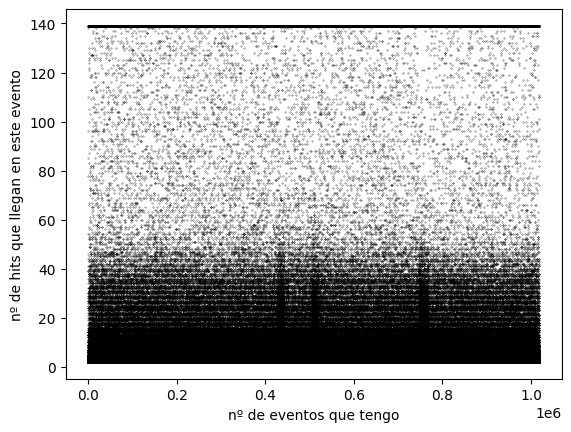

In [8]:
#3º) Puedo representar hits vs grupo para visualizar cuántos fotones llegaron en cada evento

#Eje x= índice del grupo, data_by_event (desde 0 hasta 383768)
#Eje y= númeor de hits dentro del grupo

plt.figure()
plt.scatter(hits_by_event.index, hits_by_event.values, s=0.05)
plt.xlabel("nº de eventos que tengo")
plt.ylabel("nº de hits que llegan en este evento") #aquí no sé por qué pasa esto, debería haber sólo un valor??? creo q está bn así
plt.show()

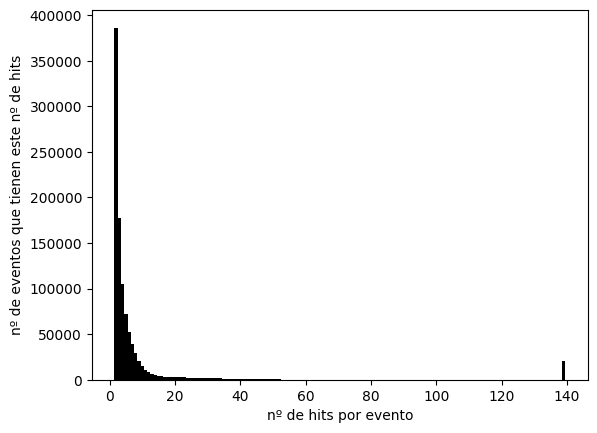

In [9]:
#4º) Ahora tengo que hacer el histograma

#usaremos: plt.hist(datos_que_queremos_graficar, bins=nº_de_barras)

hits=hits_by_event.values

#np.arange(hits.min(), hits.max()+2) crea un array que va desde el mínimo hasta el máx+2 de hits por evento (por grupo)
#se le resta 0.5 para centrar las barras del histograma en los valores enteros

bins=np.arange(hits.min(), hits.max()+2) - 0.5 

plt.figure()
plt.hist(hits, bins)
plt.xlabel("nº de hits por evento")
plt.ylabel("nº de eventos que tienen este nº de hits")
plt.show()